# MACHINE LEARNING MODEL FOR WASTE CLASSIFICATION

## Dataset

Dataset sources:

**1. RealWaste Image Classification**

source: https://www.kaggle.com/datasets/joebeachcapital/realwaste/data
+ 9 classes
+ main dataset

**2. Garbage Classification**

source: https://www.kaggle.com/datasets/mostafaabla/garbage-classification/data
+ 12 classes
+ additional dataset

The waste will be classified into 8 categories:
1. Cardboard
2. Food organics
3. Glass
4. Metal
5. Miscellaneous trash
6. Paper
7. Plastic
8. Textile trash

<!-- **2. Taco Trash Dataset**

source: https://www.kaggle.com/datasets/kneroma/tacotrashdataset && http://tacodataset.org/
- 60 categories with 28 super categories (http://tacodataset.org/taxonomy) -->

<!-- solution in mind:
1. using pre-trained model from TACO dataset to our RealWaste dataset so that we will be able to classify it into classes that we want with a lot more data.
OR
2. using only TACO dataset but we have to search more waste infos. OR
3. using RealWaste dataset only -->

<!-- additional links: -->

<!-- - pretrained model on TACO: https://www.kaggle.com/datasets/bouweceunen/trained-models-taco-trash-annotations-in-context/ -->
<!-- - TACO paper: https://arxiv.org/pdf/2003.06975 -->

# **Other Reference**
github recyclo https://github.com/ReCyclo-Bangkit-2023

## **Import libraries**


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
from PIL import Image
import requests
from io import BytesIO

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# System libraries
import os
from pathlib import Path
import os.path
import zipfile

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Data Preparation

## Load the data

In [3]:
# read and extract the zip file
zip_ref = zipfile.ZipFile('data.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [16]:
dataset_path = "data/"
image_df = pd.DataFrame()

After the zip file is extracted, the dataset will be saved in DataFrame format.

In [17]:
image_dir = Path(dataset_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

image_df

,Filepath,Label
0,data\Cardboard\cardboard1.jpg,Cardboard
1,data\Cardboard\cardboard10.jpg,Cardboard
2,data\Cardboard\cardboard100.jpg,Cardboard
3,data\Cardboard\cardboard101.jpg,Cardboard
4,data\Cardboard\cardboard102.jpg,Cardboard
...,...,...
13763,data\Textile Trash\Textile Trash_95.jpg,Textile Trash
13764,data\Textile Trash\Textile Trash_96.jpg,Textile Trash
13765,data\Textile Trash\Textile Trash_97.jpg,Textile Trash
13766,data\Textile Trash\Textile Trash_98.jpg,Textile Trash


In [18]:
class_labels = image_df['Label'].unique()
class_labels

array(['Cardboard', 'Food Organics', 'Glass', 'Metal',
       'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash'],
      dtype=object)

As the result shows, there are 13768 images of waste with 8 different categories.

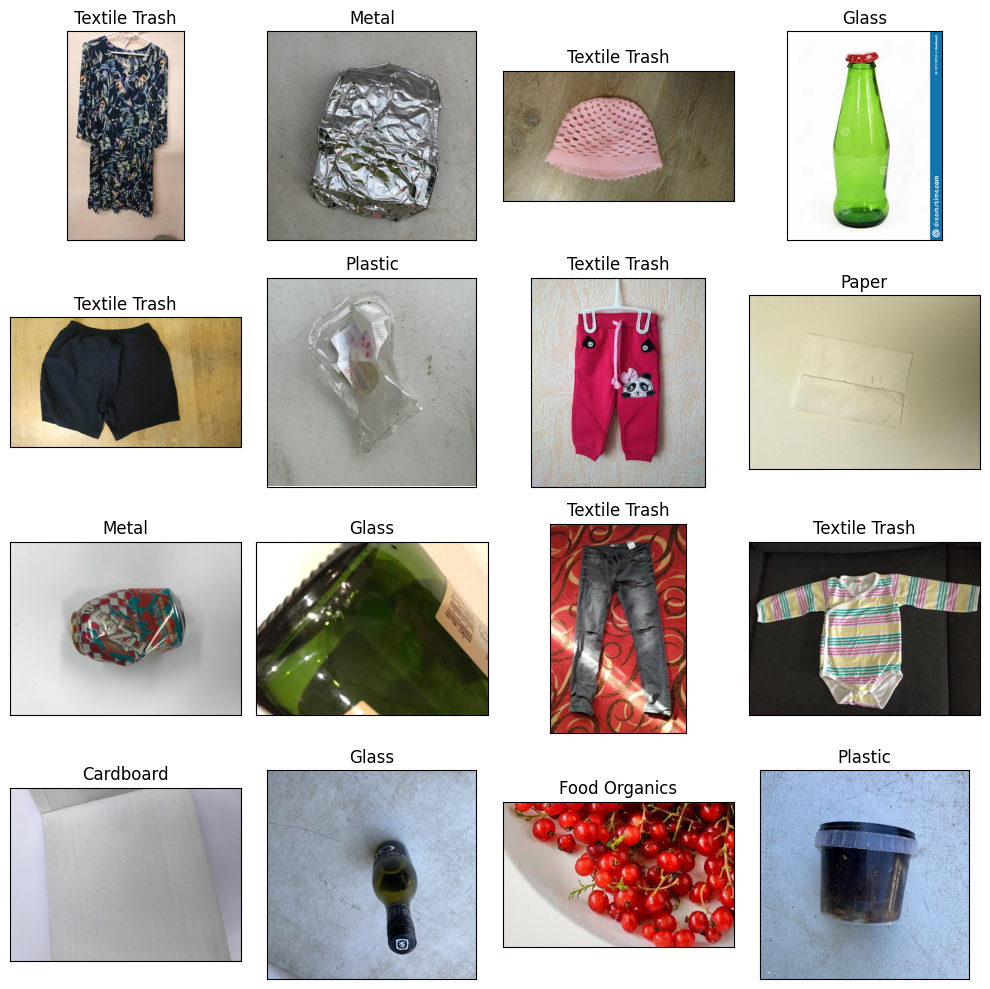

In [19]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
  ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [20]:
from sklearn.utils.class_weight import compute_class_weight

In [21]:
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=image_df['Label'])
weights

array([1.27292899, 0.93941048, 0.70793912, 1.10391276, 1.19513889,
       1.11032258, 0.96360582, 0.94664466])

In [22]:
class_counts = image_df['Label'].value_counts()
print(class_counts)

Label
Glass                  2431
Food Organics          1832
Textile Trash          1818
Plastic                1786
Metal                  1559
Paper                  1550
Miscellaneous Trash    1440
Cardboard              1352
Name: count, dtype: int64


As the result shows:
- The class with the most samples (Glass) has 2431 samples.
- The class with the fewest samples (Cardboard) has 1352 samples.

Imbalance ratio: $ \frac{2431}{1352} \approx 1.8 $

Therefore we use the SMOTE (Synthetic Minority Oversampling Technique) to oversample the data minority.

## Oversample the data

In [23]:
# Initial split into training and temp (validation+test)
train_df, temp_df = train_test_split(image_df, test_size=0.4, shuffle=True, random_state=1)

# Secondary split into validation and test from temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=1)

In [24]:
# Oversampling ---

# load data from the dataframe
load_gen = ImageDataGenerator()
smote_gen = load_gen.flow_from_dataframe(
  dataframe=train_df,
  x_col='Filepath',
  y_col='Label',
  target_size=(224, 224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  shuffle=False,
  seed=42
)

x = np.concatenate([smote_gen.next()[0] for i in range(smote_gen.__len__())])
y = np.concatenate([smote_gen.next()[1] for i in range(smote_gen.__len__())])

print(x.shape)
print(y.shape)

Found 8260 validated image filenames belonging to 8 classes.
(8260, 224, 224, 3)
(8260, 8)


In [25]:
# converting our color images to a vector
X_train = x.reshape(x.shape[0], 224*224*3)

# Apply SMOTE method
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2)
X_smote, y_smote = smote.fit_resample(X_train, y)

print(X_smote.shape)
print(y_smote.shape)

(11648, 150528)
(11648, 8)


In [26]:
# Save all images generated by the SMOTE method

Xsmote_img = X_smote.reshape(X_smote.shape[0], 224, 224, 3)
y_smote = np.argmax(y_smote, axis=1)
label = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash']

for i in range(len(Xsmote_img)):
  pil_img = array_to_img(Xsmote_img[i] * 255)
  pil_img.save(dataset_path + '/' + str(label[y_smote[i]]) + '/smote' + str(i) + '.jpg')

In [27]:
# load the smote image generated and add it to the train dataframe
smote_filepaths = list(image_dir.glob(r'**/smote*.jpg'))
smote_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], smote_filepaths))
smote_filepaths = pd.Series(smote_filepaths, name='Filepath').astype(str)
smote_labels = pd.Series(smote_labels, name='Label')

# Concatenate filepaths and labels
smote_df = pd.concat([smote_filepaths, smote_labels], axis=1)
train_df_updated = pd.concat([smote_df, train_df], axis=0)

train_df_updated

,Filepath,Label
0,data\Cardboard\smote1005.jpg,Cardboard
1,data\Cardboard\smote1006.jpg,Cardboard
2,data\Cardboard\smote1008.jpg,Cardboard
3,data\Cardboard\smote1025.jpg,Cardboard
4,data\Cardboard\smote1035.jpg,Cardboard
...,...,...
905,data\Cardboard\Cardboard_111.jpg,Cardboard
5192,data\Glass\white-glass416.jpg,Glass
12172,data\Textile Trash\clothes1199.jpg,Textile Trash
235,data\Cardboard\cardboard310.jpg,Cardboard


In [28]:
class_counts = train_df_updated['Label'].value_counts()
print(class_counts)

Label
Glass                  2912
Food Organics          2567
Plastic                2552
Textile Trash          2550
Metal                  2413
Paper                  2363
Miscellaneous Trash    2325
Cardboard              2226
Name: count, dtype: int64


Now the imbalance ratio is reduced to 1.3

## Data augmentation

In [31]:
image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [32]:
train_images = image_generator.flow_from_dataframe(
    dataframe=train_df_updated,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_images = image_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 19908 validated image filenames belonging to 8 classes.
Found 2754 validated image filenames belonging to 8 classes.
Found 2754 validated image filenames belonging to 8 classes.


In [33]:
train_images.class_indices

{'Cardboard': 0,
 'Food Organics': 1,
 'Glass': 2,
 'Metal': 3,
 'Miscellaneous Trash': 4,
 'Paper': 5,
 'Plastic': 6,
 'Textile Trash': 7}

In [34]:
class_weights = dict(zip(train_images.class_indices.values(), weights))
class_weights

{0: 1.2729289940828403,
 1: 0.9394104803493449,
 2: 0.7079391197038256,
 3: 1.1039127645926876,
 4: 1.195138888888889,
 5: 1.1103225806451613,
 6: 0.9636058230683091,
 7: 0.9466446644664467}

# Model Making

We utilize transfer learning method using MobileNetv2 trained on ImageNet dataset.

In [35]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),
                                                     include_top=False,
                                                     weights='imagenet')

# retrain the last half of the layers from MobileNetV2
layers_count = len(pretrained_model.layers)
for i in range(int(layers_count*0.5)):
    pretrained_model.layers[i].trainable = False



9406464/9406464 [==============================] - 7s 1us/step


In [36]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224, 224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
    preprocessing.RandomRotation(0.2),            # Equivalent to rotation_range=40 (0.2 * 2 * pi)
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomFlip("horizontal")
], name="data_augmentation")

In [42]:
inputs = pretrained_model.input

# # Apply preprocessing
x = resize_and_rescale(inputs)
x = data_augmentation(x)

# Add custom Dense layer
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))(pretrained_model.output)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Output layer with 9 classes
outputs = layers.Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=120)

# Data Training

In [40]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

In [43]:
history = model.fit(
    train_images,
    steps_per_epoch=train_images.samples//train_images.batch_size,
    validation_data=val_images,
    validation_steps=val_images.samples//val_images.batch_size,
    epochs=100,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
622/622 [==============================] - 829s 1s/step - loss: 3.9305 - accuracy: 0.7975 - val_loss: 1.7728 - val_accuracy: 0.8136 - lr: 1.0000e-04
Epoch 2/100
622/622 [==============================] - 612s 984ms/step - loss: 0.7545 - accuracy: 0.9367 - val_loss: 0.8724 - val_accuracy: 0.8147 - lr: 1.0000e-04
Epoch 3/100
622/622 [==============================] - 594s 955ms/step - loss: 0.2344 - accuracy: 0.9716 - val_loss: 0.6335 - val_accuracy: 0.8427 - lr: 1.0000e-04
Epoch 4/100
622/622 [==============================] - 603s 969ms/step - loss: 0.1574 - accuracy: 0.9795 - val_loss: 0.4376 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 5/100
622/622 [==============================] - 591s 950ms/step - loss: 0.1056 - accuracy: 0.9872 - val_loss: 0.4732 - val_accuracy: 0.8794 - lr: 1.0000e-04
Epoch 6/100
622/622 [==============================] - 615s 988ms/step - loss: 0.0895 - accuracy: 0.9881 - val_loss: 0.4012 - val_accuracy: 0.9019 - lr: 1.0000e-04
Epoch 7/100
622/622

# Checking the accuracy

In [44]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.33230
Test Accuracy: 92.41%


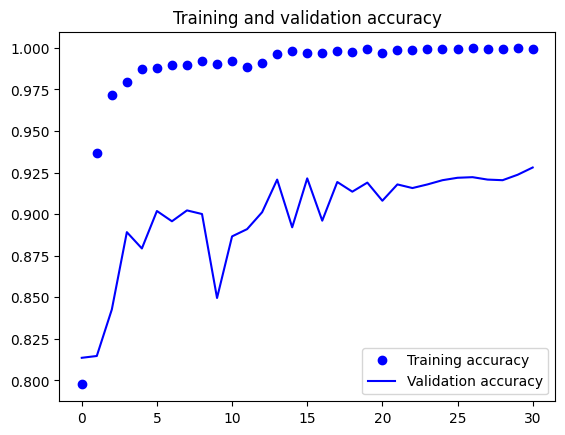

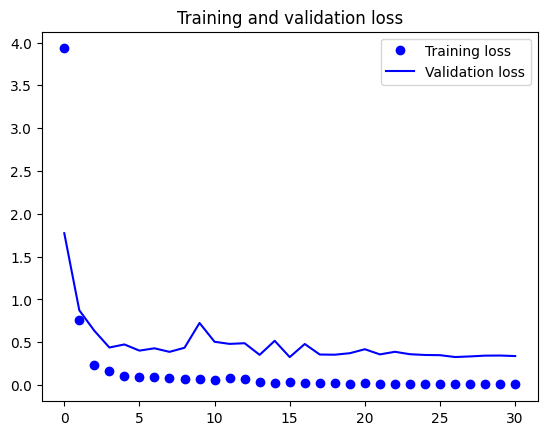

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [46]:
def evaluate_model_performance(model, val_generator, class_labels):
  """
  Evaluate the model's performance on the validation set and print the classification report.

  Parameters:
  - model: The trained model.
  - val_generator: Validation data generator.
  - class_labels: List of class names.

  Returns:
  - report: Classification report as a string.
  """

  # Getting all the true labels for the validation set
  true_labels = val_generator.classes

  # Get the class labels (names) from the generator
  class_labels = list(val_generator.class_indices.keys())

  # To get the predicted labels, we predict using the model
  predictions = model.predict(val_generator, steps=len(val_generator))

  # Take the argmax to get the predicted class indices.
  predicted_labels = np.argmax(predictions, axis=1)

  # Extracting true labels from the validation generator
  true_labels = val_generator.classes

  # Classification report
  report = classification_report(true_labels, predicted_labels, target_names=class_labels)
  print(report)
  print('\n')

  # Define a custom colormap
  colors = ["white", "royalblue"]
  cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

  # Confusion Matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  # Plotting confusion matrix using seaborn
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

87/87 [==============================] - 55s 596ms/step
                     precision    recall  f1-score   support

          Cardboard       0.89      0.95      0.92       275
      Food Organics       0.95      0.99      0.97       377
              Glass       0.93      0.96      0.94       491
              Metal       0.93      0.85      0.88       308
Miscellaneous Trash       0.95      0.85      0.90       274
              Paper       0.92      0.91      0.91       321
            Plastic       0.86      0.89      0.87       343
      Textile Trash       0.97      0.96      0.97       365

           accuracy                           0.92      2754
          macro avg       0.92      0.92      0.92      2754
       weighted avg       0.92      0.92      0.92      2754





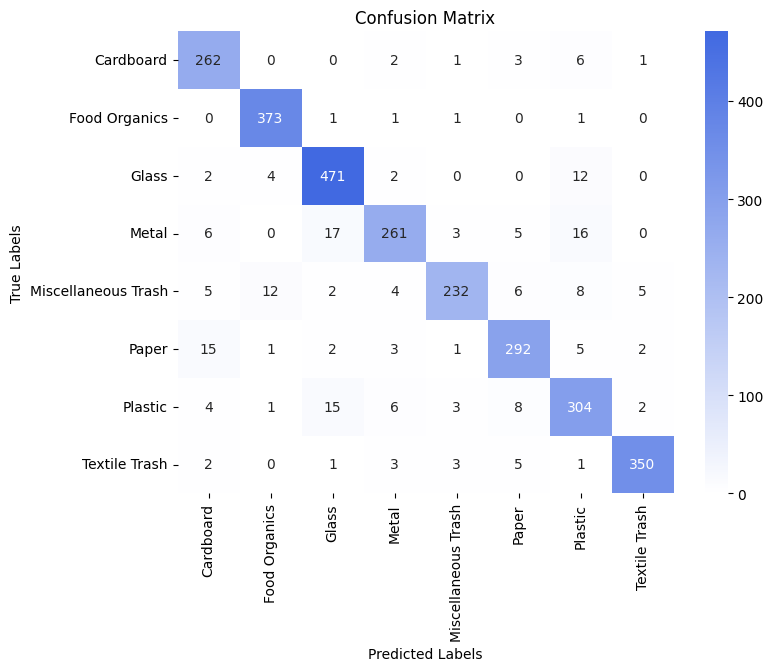

In [47]:
evaluate_model_performance(model, test_images, class_labels)

In [52]:
from PIL import Image
import numpy as np
import requests
from io import BytesIO

def load_and_preprocess_image(url, target_size):
    # download image from url
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # resize the image
    img = img.resize(target_size)

    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# test the model using image from the internet
url = 'https://images.herzindagi.info/image/2023/Oct/bottle-cleaning.jpg'

target_size = (300, 300)
img_array = load_and_preprocess_image(url, target_size)


In [53]:
# predict
predictions = model.predict(img_array)
print(predictions)

class_names = ['Cardboard',
              'Food Organics',
              'Glass',
              'Metal',
              'Miscellaneous Trash',
              'Paper',
              'Plastic',
              'Textile Trash']

# get its label
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted class: {predicted_class_name}')


1/1 [==============================] - 0s 151ms/step
[[1.6480258e-04 1.8497329e-04 9.9933511e-01 2.1609763e-05 5.2575742e-05
  4.7955662e-05 8.0618418e-05 1.1229184e-04]]
Predicted class: Glass


In [54]:
# predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# display the result
print(f'The first 5 predictions: {pred[:5]}')

87/87 [==============================] - 52s 599ms/step
The first 5 predictions: ['Miscellaneous Trash', 'Metal', 'Paper', 'Textile Trash', 'Textile Trash']


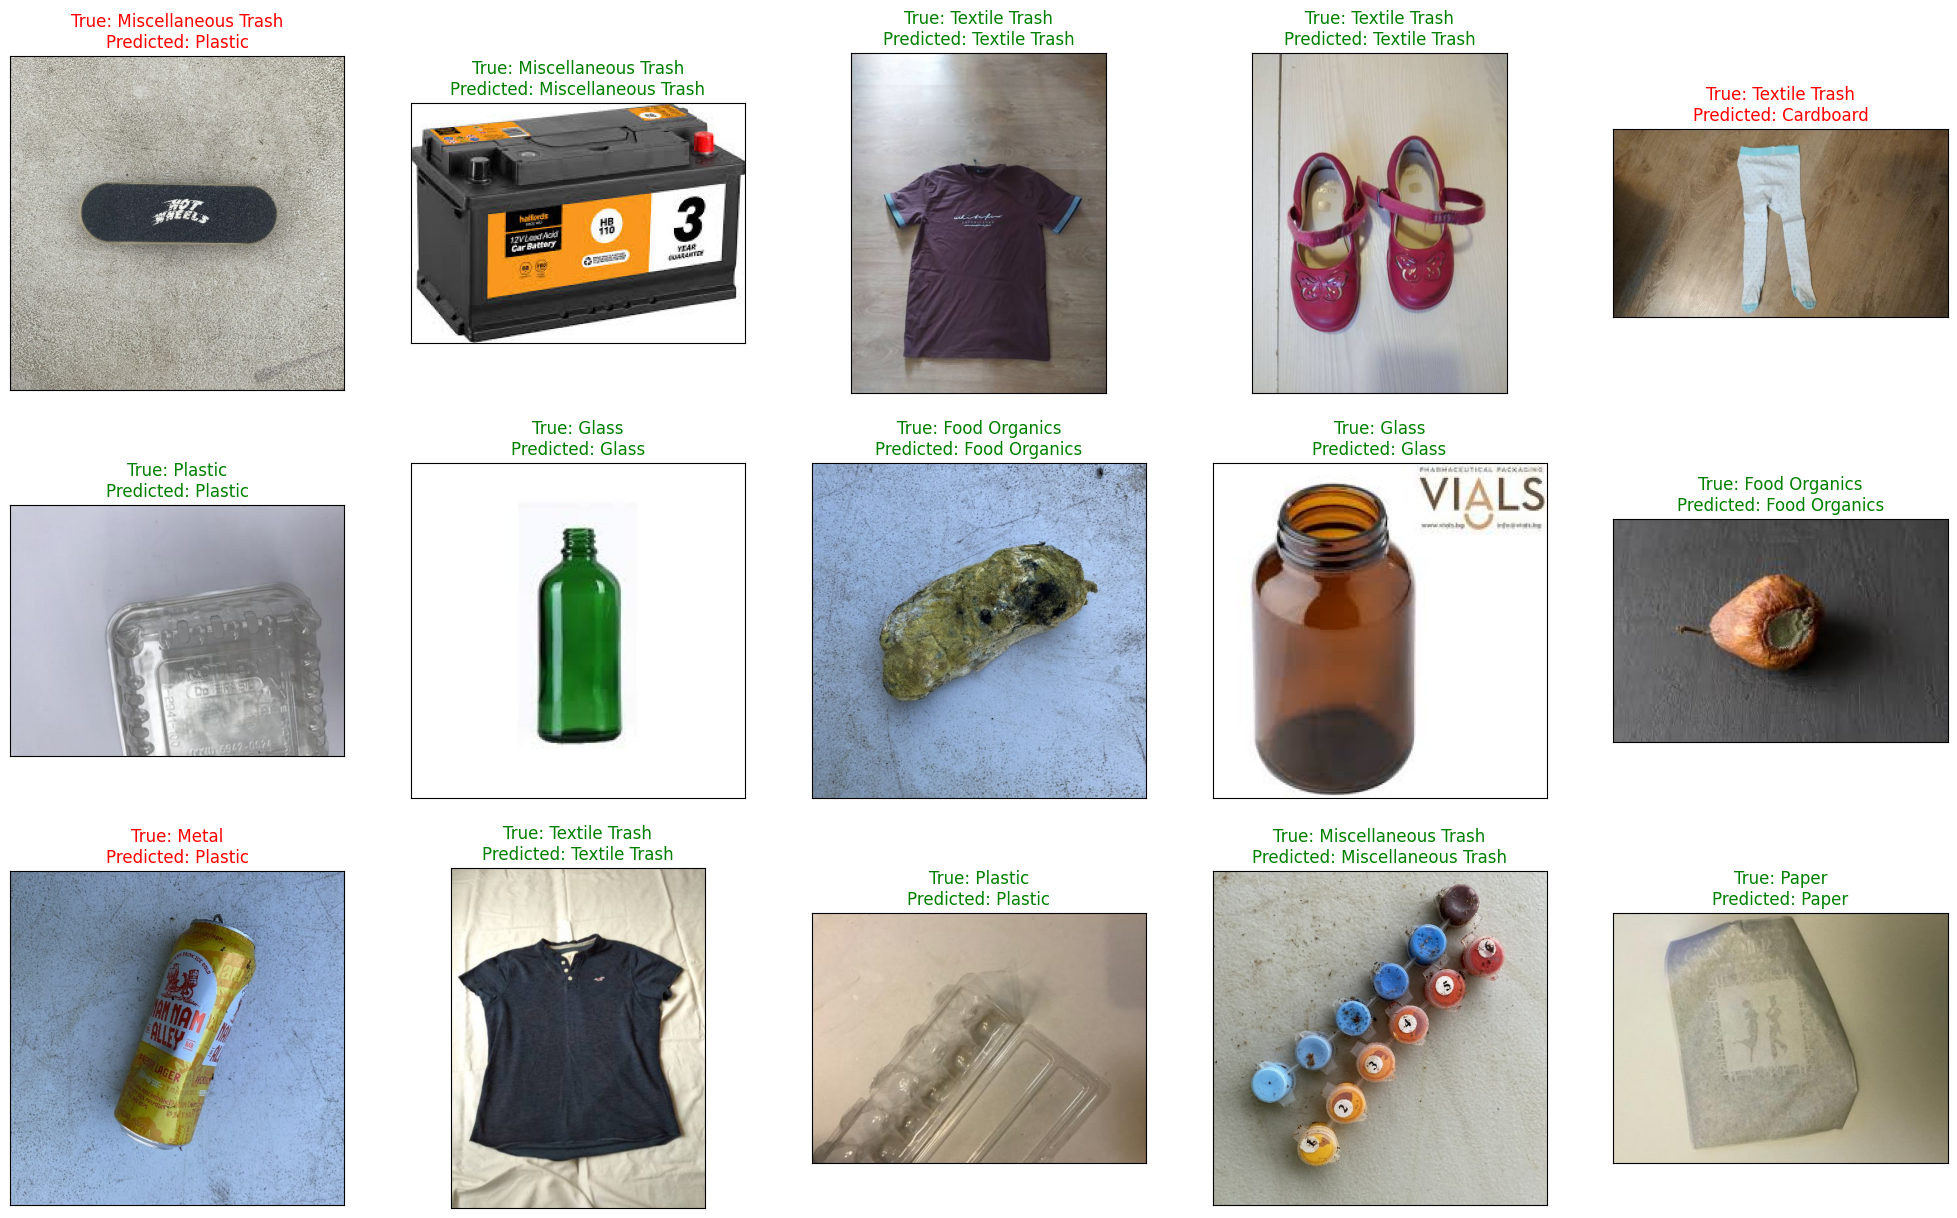

<Figure size 640x480 with 0 Axes>

In [55]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Converting model to .tflite

In [ ]:
export_dir = '/tmp/saved_model/'

In [ ]:
# Re-save the model with the compatible TF version
tf.saved_model.save(model, export_dir)
model.save("my_model.h5")

In [ ]:
model_file = "my_model.h5"  # Replace with your model filename
model_size_bytes = os.stat(model_file).st_size
model_size_mb = model_size_bytes / 1048576

print(f"Model size: {model_size_mb:.2f} MB")

In [ ]:
# Convert the model
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
# Save the model
tflite_model_file = pathlib.Path('/tmp/ver1.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
from google.colab import files

files.download(tflite_model_file)

# Converting model into JSON file

In [57]:
saved_model_path = "./deployment/my_model.h5"

model.save(saved_model_path)

In [ ]:
!pip install tensorflowjs

In [ ]:
# Using the tensorflow.js converter to convert the saved Keras model into JSON format.
!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model {saved_model_path} ./deployment

In [ ]:
# zip the bin files and json file
!zip model-json.zip *.bin model.json